# MuJoCo Installation

In [1]:
!pip install -q mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 28.8 MB/s eta 0:00:00


In [2]:
# @title Check if installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
# @title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00


# Mujoco Codes

In [4]:
# @title Show Body
xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" integrator="RK4"/>

    <default>
        <joint armature="1" damping="1" limited="true"/>
        <geom conaffinity="0" condim="3" density="5.0" friction="1 0.5 0.5" margin="0.01" rgba="0.8 0.6 0.4 1"/>
    </default>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="1 1 0.2" type="plane"/>
         <camera name="fixed" pos="-0.3 -0.7 .5" xyaxes="1 0 0 0 1 2" mode="track" />

        <body name="core" pos="0 0 0.8" euler="0 0 0">
            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>

            <geom name="core_geom" type="box" pos="0 0 0" quat="1 0 0 0" size=".04 .04 .02" rgba=".9 .3 .8 1" mass=".1"/>

            <geom name="arm_front_left" type="box" pos=".07 .07 0" size=".05 .005 .005" quat=".924 0 0 .383" rgba=".3 .3 .8 1" mass=".025"/>
            <geom name="arm_front_right" type="box" pos=".07 -.07 0" size=".05 .005 .005" quat=".383 0 0 .924" rgba=".3 .3 .8 1" mass=".025"/>
            <geom name="arm_back_right" type="box" pos="-.07 -.07 0" size=".05 .005 .005" quat="-.383 0 0 .924" rgba=".3 .3 .8 1" mass=".025"/>
            <geom name="arm_back_left" type="box" pos="-.07 .07 0" size=".05 .005 .005" quat=".924 0 0 -.383" rgba=".3 .3 .8 1" mass=".025"/>

            <site name="motor_front_left" type="cylinder" pos=".1 .1 .0075" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
            <site name="motor_front_right" type="cylinder" pos=".1 -.1 .0075" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
            <site name="motor_back_right" type="cylinder" pos="-.1 -.1 .0075" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
            <site name="motor_back_left" type="cylinder" pos="-.1  .1 .0075" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

            <geom name="thruster_front_left" type="cylinder" pos=".1 .1 .0075" size=".05 .0025" quat="1 0 0 0" rgba=".3 .8 .3 0.6" mass=".025"/>
            <geom name="thruster_front_right" type="cylinder" pos=".1 -.1 .0075" size=".05 .0025" quat="1 0 0 0" rgba=".3 .8 .3 0.6" mass=".025"/>
            <geom name="thruster_back_right" type="cylinder" pos="-.1 -.1 .0075" size=".05 .0025" quat="1 0 0 0" rgba=".3 .8 .3 0.6" mass=".025"/>
            <geom name="thruster_back_left" type="cylinder" pos="-.1 .1 .0075" size=".05 .0025" quat="1 0 0 0" rgba=".3 .8 .3 0.6" mass=".025"/>

        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0 0 1 0 0 -.1" site="motor_front_left"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0 0 1 0 0 .1" site="motor_back_left"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0 0 1 0 0 -.1" site="motor_back_right"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0 0 1 0 0 .1" site="motor_front_right"/>
    </actuator>


</mujoco>
"""

# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# # Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)

duration = 3.8  # (seconds)
framerate = 10  # (Hz)
# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  data.ctrl[1] = 0.738
  data.ctrl[2] = 0.738
  data.ctrl[0] = 0.735
  data.ctrl[3] = 0.735
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [5]:
# @title Show Body
xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" integrator="RK4"/>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="5 5 0.2" type="plane"/>
        <body name="core" pos="0 0 0.2" >
            <geom name="core_geom" type="box" pos="0 0 0" quat="1 0 0 0" size=".04 .04 .02" rgba=".8 .2 0 1" mass=".1"/>
            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>
            <geom name="arm_front0" type="box" pos=".08 0 0" size=".04 .005 .005" quat="1 0 0 0" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_back0" type="box" pos="-.08 0 0" size=".04 .005 .005" quat="0 0 0 1" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_left0" type="box" pos="0 .08 0" size=".04 .005 .005" quat=".707 0 0 .707" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_right0" type="box" pos="0 -.08 0" size=".04 .005 .005" quat=".707 0 0 -.707" rgba=".8 .8 .8 1" mass=".02"/>

            <body name="arm_front1" pos=".12 0 0">
                <geom type="box" pos=".01 0 .005" size=".01 .005 .01" quat="1 0 0 0" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster0" pos="0.01 0 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor0" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_back1" pos="-.12 0 0">
                <geom type="box" pos="-.01 0 .005" size=".01 .005 .01" quat="0 0 0 1" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster1" pos="-0.01 0 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor1" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_left1" pos="0 .12 0">
                <geom type="box" pos="0 .01 .005" size=".01 .005 .01" quat=".7071068 0 0 .7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster2" pos="0 0.01 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor2" type="cylinder" pos="0 0 .0025" size=".01 0.0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_right1" pos="0 -.12 0">
                <geom type="box" pos="0 -.01 .005" size=".01 .005 .01" quat=".7071068 0 0 -.7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster3" pos="0 -0.01 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1" name="motor3"/>
                </body>

            <site name="x_axis" type="box" pos=".1 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.3"/>
            <site name="y_axis" type="box" pos="0 .1 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.3"/>
            <site name="z_axis" type="box" pos="0 0 .1" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.3"/>
            </body>


        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor3"/>
    </actuator>
</mujoco>
"""

# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# # Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)

duration = 3.8  # (seconds)
framerate = 10  # (Hz)
# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  data.ctrl[1] = 0.738
  data.ctrl[2] = 0.738
  data.ctrl[0] = 0.735
  data.ctrl[3] = 0.735
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

12


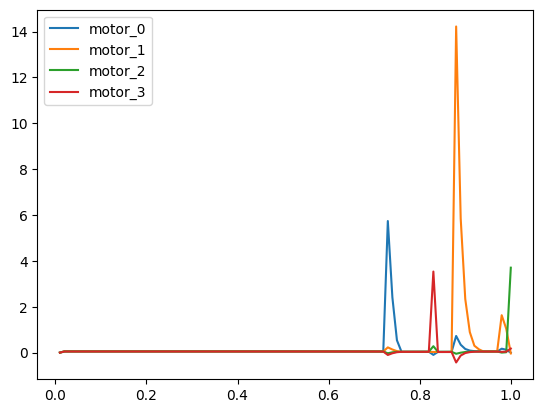

In [6]:
# @title Show Axis
xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" integrator="RK4"/>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="5 5 0.2" type="plane"/>
        <body name="core" pos="-.3 0 0.3" euler="0 10 0">
            <geom name="core_geom" type="box" pos="0 0 0" quat="1 0 0 0" size=".04 .04 .02" rgba=".8 .2 0 1" mass=".1"/>
            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>
            <geom name="arm_front0" type="box" pos=".08 0 0" size=".04 .005 .005" quat="1 0 0 0" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_back0" type="box" pos="-.08 0 0" size=".04 .005 .005" quat="0 0 0 1" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_left0" type="box" pos="0 .08 0" size=".04 .005 .005" quat=".707 0 0 .707" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_right0" type="box" pos="0 -.08 0" size=".04 .005 .005" quat=".707 0 0 -.707" rgba=".8 .8 .8 1" mass=".02"/>

            <body name="arm_front1" pos=".12 0 0">
                <geom type="box" pos=".01 0 .005" size=".01 .005 .01" quat="1 0 0 0" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster0" pos="0.01 0 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor0" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.8"/>
                </body>
            </body>

            <body name="arm_back1" pos="-.12 0 0">
                <geom type="box" pos="-.01 0 .005" size=".01 .005 .01" quat="0 0 0 1" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster1" pos="-0.01 0 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor1" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.8"/>
                </body>
            </body>

            <body name="arm_left1" pos="0 .12 0">
                <geom type="box" pos="0 .01 .005" size=".01 .005 .01" quat=".7071068 0 0 .7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster2" pos="0 0.01 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor2" type="cylinder" pos="0 0 .0025" size=".01 0.0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.8"/>
                </body>
            </body>

            <body name="arm_right1" pos="0 -.12 0">
                <geom type="box" pos="0 -.01 .005" size=".01 .005 .01" quat=".7071068 0 0 -.7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster3" pos="0 -0.01 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1" name="motor3"/>

                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.8"/>
                </body>

            </body>

                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="1 0 0 0" rgba="1 0 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat=".707 0 0 .707" rgba="0 1 0 0.8"/>
                    <site type="box" pos="0 0 0" size=".1 .005 .005" quat="-.707 0 .707 0" rgba="0 0 1 0.8"/>

        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor3"/>
    </actuator>

    <sensor>
    <force site="motor0"/>
    <force site="motor1"/>
    <force site="motor2"/>
    <force site="motor3"/>
    </sensor>


</mujoco>
"""

# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# # Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)

duration = 1  # (seconds)
framerate = 10  # (Hz)
# Simulate and display video.
frames = []
v_m0 = []
v_m1 = []
v_m2 = []
v_m3 = []
t=[]
print(len(data.sensordata))
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  data.ctrl[1] = .73
  data.ctrl[2] = .73
  data.ctrl[0] = .7
  data.ctrl[3] = .7

  # read the sensor data
  v_m0.append(data.sensordata[2])
  v_m1.append(data.sensordata[5])
  v_m2.append(data.sensordata[8])
  v_m3.append(data.sensordata[11])
  t.append(data.time)

  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

plt.plot(t, v_m0, t, v_m1, t, v_m2, t, v_m3)
plt.legend(["motor_0","motor_1","motor_2","motor_3"])
plt.show()

media.show_video(frames, fps=framerate)

""

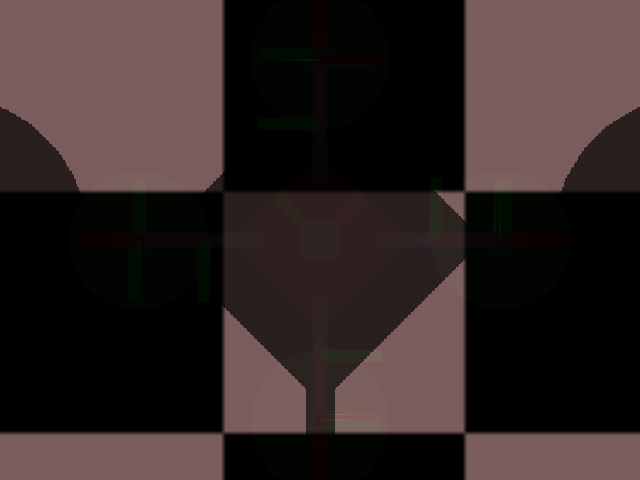

In [7]:

xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" integrator="RK4"/>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="5 5 0.2" type="plane"/>
            <camera name="fixed" pos="-0.3 -0.7 .5" xyaxes="1 0 0 0 1 2"/>

        <body name="core" pos="-.3 -.1 0.2" euler="0 0 0">

            <camera name="proof" pos="0 0 0" euler="0 0 0"/>

            <geom name="core_geom" type="box" pos="0 0 0" euler="0 0 45" size=".04 .04 .02" rgba=".8 .2 0 1" mass=".1"/>
            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>
            <geom name="arm_front0" type="box" pos=".08 0 0" size=".04 .005 .005" quat="1 0 0 0" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_back0" type="box" pos="-.08 0 0" size=".04 .005 .005" quat="0 0 0 1" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_left0" type="box" pos="0 .08 0" size=".04 .005 .005" quat=".707 0 0 .707" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_right0" type="box" pos="0 -.08 0" size=".04 .005 .005" quat=".707 0 0 -.707" rgba=".8 .8 .8 1" mass=".02"/>

            <body name="arm_front1" pos=".12 0 0">
                <geom type="box" pos=".01 0 .005" size=".01 .005 .01" quat="1 0 0 0" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster0" pos="0.01 0 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor0" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_back1" pos="-.12 0 0">
                <geom type="box" pos="-.01 0 .005" size=".01 .005 .01" quat="0 0 0 1" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster1" pos="-0.01 0 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor1" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_left1" pos="0 .12 0">
                <geom type="box" pos="0 .01 .005" size=".01 .005 .01" quat=".7071068 0 0 .7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster2" pos="0 0.01 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor2" type="cylinder" pos="0 0 .0025" size=".01 0.0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_right1" pos="0 -.12 0">
                <geom type="box" pos="0 -.01 .005" size=".01 .005 .01" quat=".7071068 0 0 -.7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster3" pos="0 -0.01 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1" name="motor3"/>

                </body>

            </body>

        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  0.1" site="motor3"/>
    </actuator>

    <sensor>
    <force site="motor0"/>
    <force site="motor1"/>
    <force site="motor2"/>
    <force site="motor3"/>
    </sensor>


</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

mujoco.mj_forward(model, data)
# renderer.update_scene(data)
renderer = mujoco.Renderer(model, 480, 640)
# media.show_image(renderer.render())


scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
renderer.update_scene(data, scene_option=scene_option, camera="proof")
frame = renderer.render()
media.show_image(frame)

## Moving Camera

In [8]:
# @title Show Body
xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" integrator="RK4"/>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" specular="1" texrepeat="50 50" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="5 5 0.2" type="plane"/>
            <camera name="fixed" pos="-0.3 -0.7 .5" xyaxes="1 0 0 0 1 2" />

        <body name="core" pos="-.3 -.1 0.2" euler="0 0 0">

            <camera name="camera_sensor" pos="0 0 0" euler="0 0 0"/>

            <geom name="core_geom" type="box" pos="0 0 0" euler="0 0 45" size=".04 .04 .02" rgba=".8 .2 0 1" mass=".1"/>
            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>
            <geom name="arm_front0" type="box" pos=".08 0 0" size=".04 .005 .005" quat="1 0 0 0" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_back0" type="box" pos="-.08 0 0" size=".04 .005 .005" quat="0 0 0 1" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_left0" type="box" pos="0 .08 0" size=".04 .005 .005" quat=".707 0 0 .707" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_right0" type="box" pos="0 -.08 0" size=".04 .005 .005" quat=".707 0 0 -.707" rgba=".8 .8 .8 1" mass=".02"/>

            <body name="arm_front1" pos=".12 0 0">
                <geom type="box" pos=".01 0 .005" size=".01 .005 .01" quat="1 0 0 0" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster0" pos="0.01 0 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor0" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_back1" pos="-.12 0 0">
                <geom type="box" pos="-.01 0 .005" size=".01 .005 .01" quat="0 0 0 1" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster1" pos="-0.01 0 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor1" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_left1" pos="0 .12 0">
                <geom type="box" pos="0 .01 .005" size=".01 .005 .01" quat=".7071068 0 0 .7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster2" pos="0 0.01 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor2" type="cylinder" pos="0 0 .0025" size=".01 0.0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_right1" pos="0 -.12 0">
                <geom type="box" pos="0 -.01 .005" size=".01 .005 .01" quat=".7071068 0 0 -.7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster3" pos="0 -0.01 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1" name="motor3"/>

                </body>

            </body>

        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0. -1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0 1" gear="0  0. 1. 0. 0.  1" site="motor3"/>
    </actuator>

    <sensor>
      <force site="motor0"/>
      <force site="motor1"/>
      <force site="motor2"/>
      <force site="motor3"/>
    </sensor>


</mujoco>
"""

# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# # Make renderer, render and show the pixels
# renderer = mujoco.Renderer(model)
renderer = mujoco.Renderer(model, 480, 640)

duration = 2  # (seconds)
framerate = 10  # (Hz)
# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

print(f"data.act:{data.act.shape}\n{data.act}") # prints (0,) and []
print(f"data.qfrc_applied:{data.qfrc_applied.shape}\n{data.qfrc_applied}") # all 0
print(f"data.actuator_force:{data.actuator_force.shape}\n{data.actuator_force}") # equal to T
print(f"data.qfrc_actuator:{data.qfrc_actuator.shape}\n{data.qfrc_actuator}") # equal to nT


while data.time < duration:
  mujoco.mj_step(model, data)
  data.ctrl[1] = 0.7
  data.ctrl[2] = 0.7
  data.ctrl[0] = 0.7
  data.ctrl[3] = 0.7

  if len(frames) < data.time * framerate:
    renderer.update_scene(data, camera="fixed")
    pixels = renderer.render()
    # print(data.actuator_gear)
    frames.append(pixels)

media.show_video(frames, fps=framerate)


data.act:(0,)
[]
data.qfrc_applied:(6,)
[0. 0. 0. 0. 0. 0.]
data.actuator_force:(4,)
[0. 0. 0. 0.]
data.qfrc_actuator:(6,)
[0. 0. 0. 0. 0. 0.]
